In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [14]:
data_path = '../../data/postprocessed/NCU/'

mapping_table = {
    'NN50PercLeNet5': 'LeNet5',
    'NN50Percmnasnet05': 'MnasNet',
    'NN50Percmobilenetv2': 'MobileNetV2',
    'NN50Percresnet18': 'ResNet18',
    'gpuburn5min': 'GPU-burn'
}

data_sheet = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (('NN50Perc' in file or '5min' in file) and not 'telemetry' in file)]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    df['progress'] = (df['session_id'] - df['session_id'].min()) / (df['session_id'].max() - df['session_id'].min()) * 100
    # print(df[df.isna()])
    data_sheet=pd.concat([data_sheet, df], ignore_index=True)

../../data/postprocessed/NCU/NN50PercLeNet5_1.csv
../../data/postprocessed/NCU/gpuburn5min_1.csv
../../data/postprocessed/NCU/NN50Percresnet18_1.csv
../../data/postprocessed/NCU/NN50Percmnasnet05_1.csv
../../data/postprocessed/NCU/NN50Percmobilenetv2_1.csv


## Fixing the set of computed metrics across all the experiments

### I want to check if the number of Kernel Injection (Range) affects the number of run sessions.

In [15]:
for label in sorted(data_sheet['Range'].unique()):
    print("--------------------------------------------------------------------")
    print(f'Number of times a kernel is executed for metric computation: {label}') 
    print(f"Instances: {len(data_sheet[data_sheet['Range']==label])}")

--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 1
Instances: 208280


### Apparently not

### Thus, it must be dependent only on the application complexity

In [16]:
for label in mapping_table.values():
    print("--------------------------------------------------------------------")
    print(f'App name: {label}') 
    print(f"Instances: {len(data_sheet[data_sheet['App_name']==label])}")

--------------------------------------------------------------------
App name: LeNet5
Instances: 65120
--------------------------------------------------------------------
App name: MnasNet
Instances: 39360
--------------------------------------------------------------------
App name: MobileNetV2
Instances: 59400
--------------------------------------------------------------------
App name: ResNet18
Instances: 41280
--------------------------------------------------------------------
App name: GPU-burn
Instances: 3120


In [17]:
data_sheet.isna().sum()

session_id          0
duration_ms         0
location            0
metric_name         0
rollup_operation    0
range_name          0
metric_value        0
Range               0
App_name            0
progress            0
dtype: int64

### Considerations
1. Complexity does not imply stress
2. I think that the complexity is due also to the number of kernels that the application comprises

TODO: look at Future works

In [18]:
data_sheet['rollup_operation'].unique()
# It is a useless column, we can drop it
data_sheet = data_sheet.drop('rollup_operation', axis=1)

### Available data

In [19]:
location_mapping={
    'sm': 'Streaming Multiprocessor',
    'smsp': 'Streaming Multiprocessor SubPartition',
    'l1tex': 'L1 Cache',
    'dram': 'Dynamic RAM',
}
data_sheet['location'].unique()

array(['sm', 'l1tex', 'smsp', 'dram'], dtype=object)

In [20]:
data_sheet['HR_location'] = data_sheet['location'].map(location_mapping)
# data_sheet.drop('location', axis=1, inplace=True)

In [21]:
metric_event_mapping= {
    'warps_active': 'Achieved occupancy in terms of active warps',
    't_set_accesses_pipe_lsu_mem_global_op_atom': 'Atomic operations accessing global memory',
    't_set_accesses_pipe_lsu_mem_global_op_red': 'Reduction operations accessing global memory',
    'sass_average_branch_targets_threads_uniform': 'Average Branch Target Uniformity per Warp',
    'inst_executed_pipe_cbu': 'Control & Branch Instructions Executed per SM Sub-Partition',
    'inst_executed_pipe_adu': 'Address Calculation Instructions Executed per SM Sub-Partition',
    'inst_executed_pipe_fp64': 'Double-Precision Floating Point Instructions Executed per SM Sub-Partition',
    'bytes_read': 'Total Global Memory Bytes Read (DRAM)',
    'throughput': 'DRAM utilization',
    'bytes_write': 'Total Global Memory Bytes Read (DRAM)',
    'warps_eligible': 'Eligible Warps per SM Sub-Partition (Ready for Execution)',
    't_sectors_pipe_lsu_mem_global_op_ld_lookup_hit': 'Global Memory Load Sectors – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_st_lookup_hit': 'Global Memory Store Sectors – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_red_lookup_hit': 'Global Memory Reduction – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_atom_lookup_hit': 'Global Memory Atomic – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_ld': ' Global Memory Load Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_st': ' Global Memory Store Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_red': 'Global Memory Reduction Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_atom': 'Global Memory Atomic Sectors Served by L1 Cache (via LSU)',
    'sass_thread_inst_executed_op_fp64_pred_on': 'FP64 Instructions Executed per Thread with Predication ON (SM)', ## 
    'sass_thread_inst_executed_op_integer_pred_on': 'Integer Instructions Executed per Thread with Predication ON (SM)',
    'warp_issue_stalled_imc_miss_per_warp_active': 'Warp Issue Stalls Due to IMC (Immediate Constant Cache) Misses per Active Warp ',
    'warp_issue_stalled_short_scoreboard_per_warp_active': 'Warp Issue Stalls Due to Short Scoreboard (Resource Wait) per Active Warp',
    'warp_issue_stalled_wait_per_warp_active': 'Warp Issue Stalls Due to Wait (Resource/Data Not Ready) per Active Warp',
    'warp_issue_stalled_long_scoreboard_per_warp_active': 'Warp Issue Stalls Due to Long Scoreboard (Long Wait for Resource) per Active Warp',
    'warp_issue_stalled_drain_per_warp_active': 'Warp Issue Stalls Due to Drain (Memory/Resource Write Completion) per Active Warp',
    'warp_issue_stalled_lg_throttle_per_warp_active': 'Warp Issue Stalls Due to Large Unit Throttling (Resource Limitation) per Active Warp',
    'warp_issue_stalled_not_selected_per_warp_active': 'Warp Issue Stalls Due to Not Being Selected per Active Warp',
    'warp_issue_stalled_dispatch_stall_per_warp_active': 'Warp Issue Stalls Due to Dispatch Stall per Active Warp',
    'warp_issue_stalled_math_pipe_throttle_per_warp_active': 'Warp Issue Stalls Due to Math Pipe Throttling per Active Warp',
    'warp_issue_stalled_misc_per_warp_active': 'Warp Issue Stalls Due to Miscellaneous Issues per Active Warp',
    'warp_issue_stalled_mio_throttle_per_warp_active': 'Warp Issue Stalls Due to MIO Throttling per Active Warp',
    'warp_issue_stalled_sleeping_per_warp_active': 'Warp Issue Stalls Due to Sleeping per Active Warp',
    'warp_issue_stalled_barrier_per_warp_active': 'Warp Issue Stalls Due to Barrier per Active Warp',
    'warp_issue_stalled_membar_per_warp_active': 'Warp Issue Stalls Due to Membar per Active Warp',
    'warp_issue_stalled_tex_throttle_per_warp_active': 'Warp Issue Stalls Due to Texture Throttling per Active Warp',
    'thread_inst_executed_per_inst_executed': 'Thread Instructions Executed per Instructions Executed'
}
data_sheet['metric_name'].unique()

array(['warps_active', 't_set_accesses_pipe_lsu_mem_global_op_atom',
       't_set_accesses_pipe_lsu_mem_global_op_red',
       'sass_average_branch_targets_threads_uniform',
       'inst_executed_pipe_cbu', 'inst_executed_pipe_adu',
       'inst_executed_pipe_fp64', 'bytes_read', 'throughput',
       'bytes_write', 'warps_eligible',
       't_sectors_pipe_lsu_mem_global_op_ld_lookup_hit',
       't_sectors_pipe_lsu_mem_global_op_st_lookup_hit',
       't_sectors_pipe_lsu_mem_global_op_red_lookup_hit',
       't_sectors_pipe_lsu_mem_global_op_atom_lookup_hit',
       't_sectors_pipe_lsu_mem_global_op_ld',
       't_sectors_pipe_lsu_mem_global_op_st',
       't_sectors_pipe_lsu_mem_global_op_red',
       't_sectors_pipe_lsu_mem_global_op_atom', 'inst_executed',
       'sass_thread_inst_executed_op_fp64_pred_on',
       'sass_thread_inst_executed_op_integer_pred_on',
       'warp_issue_stalled_imc_miss_per_warp_active',
       'warp_issue_stalled_short_scoreboard_per_warp_active',
      

In [22]:
data_sheet['HR_metric_name'] = data_sheet['metric_name'].map(metric_event_mapping)
data_sheet.drop('metric_name', axis=1, inplace=True)

In [23]:
data_sheet['HR_metric_name'].unique()

array(['Achieved occupancy in terms of active warps',
       'Atomic operations accessing global memory',
       'Reduction operations accessing global memory',
       'Average Branch Target Uniformity per Warp',
       'Control & Branch Instructions Executed per SM Sub-Partition',
       'Address Calculation Instructions Executed per SM Sub-Partition',
       'Double-Precision Floating Point Instructions Executed per SM Sub-Partition',
       'Total Global Memory Bytes Read (DRAM)', 'DRAM utilization',
       'Eligible Warps per SM Sub-Partition (Ready for Execution)',
       'Global Memory Load Sectors – Cache Hit (per Thread Set via LSU)',
       'Global Memory Store Sectors – Cache Hit (per Thread Set via LSU)',
       'Global Memory Reduction – Cache Hit (per Thread Set via LSU)',
       'Global Memory Atomic – Cache Hit (per Thread Set via LSU)',
       ' Global Memory Load Sectors Served by L1 Cache (via LSU)',
       ' Global Memory Store Sectors Served by L1 Cache (via LSU)',


### Let's fix for a second the Number of times a kernel is executed for metric computations to 1

In [24]:
data_sheet['Range'].dtypes

dtype('int64')

In [25]:
data_sheet_1 = data_sheet[data_sheet['Range']==1]

### Regardless of the application I want to see the correlation within the columns

In [26]:
df_sm = data_sheet_1[data_sheet_1['HR_location']=='Streaming Multiprocessor']
df_smsp = data_sheet_1[data_sheet_1['HR_location']=='Streaming Multiprocessor SubPartition']
df_l1 = data_sheet_1[data_sheet_1['HR_location']=='L1 Cache']
df_dram = data_sheet_1[data_sheet_1['HR_location']=='Dynamic RAM']

dfs = {
    'Streaming Multiprocessor': df_sm, 
    'Streaming Multiprocessor SubPartition': df_smsp,
    'L1 Cache': df_l1,
    'Dynamic RAM':df_dram
    }

In [27]:
df_pivot_smsp = df_smsp.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()
df_pivot_smsp.rename({'sass_average_branch_targets_threads_uniform': 'Branch efficiency'})
df_pivot_smsp['CF Executed'] = df_pivot_smsp['inst_executed_pipe_cbu'] + df_pivot_smsp['inst_executed_pipe_adu']
df_pivot_smsp.rename({'inst_executed_pipe_fp64': 'Double precision FU utilization'})
df_pivot_smsp.rename({'warps_eligible': 'Eligible Warps per cycle'})
df_pivot_smsp.rename({'inst_executed': 'Executed instructions'})
df_pivot_smsp.rename({'sass_thread_inst_executed_op_fp64_pred_on': 'Floating point instructions'})
df_pivot_smsp.rename({'sass_thread_inst_executed_op_integer_pred_on': 'Integer instructions'})
df_pivot_smsp['Stalls'] = (df_pivot_smsp['warp_issue_stalled_imc_miss_per_warp_active']\
    + df_pivot_smsp['warp_issue_stalled_short_scoreboard_per_warp_active']\
    + df_pivot_smsp['warp_issue_stalled_wait_per_warp_active']\
    + df_pivot_smsp['warp_issue_stalled_long_scoreboard_per_warp_active']\
    + df_pivot_smsp['warp_issue_stalled_drain_per_warp_active']\
    + df_pivot_smsp['warp_issue_stalled_lg_throttle_per_warp_active']\
    + df_pivot_smsp['warp_issue_stalled_not_selected_per_warp_active']\
    + df_pivot_smsp['warp_issue_stalled_dispatch_stall_per_warp_active']\
    + df_pivot_smsp['warp_issue_stalled_misc_per_warp_active']\
    + df_pivot_smsp['warp_issue_stalled_math_pipe_throttle_per_warp_active']\
    + df_pivot_smsp['warp_issue_stalled_mio_throttle_per_warp_active']\
    + df_pivot_smsp['warp_issue_stalled_sleeping_per_warp_active']\
    + df_pivot_smsp['warp_issue_stalled_barrier_per_warp_active']\
    + df_pivot_smsp['warp_issue_stalled_membar_per_warp_active']\
    + df_pivot_smsp['warp_issue_stalled_tex_throttle_per_warp_active']) / 15

df_pivot_l1 = df_l1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_dram = df_dram.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sm = df_sm.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

pivot_dfs = {
    'Streaming Multiprocessor': df_pivot_sm, 
    'Streaming Multiprocessor SubPartition': df_pivot_smsp,
    'L1 Cache': df_pivot_l1,
    'Dynamic RAM':df_pivot_dram
    }

In [28]:
metric_full_name = data_sheet_1['HR_location'] +' '+ data_sheet_1['HR_metric_name']
metric_full_name

0         Streaming Multiprocessor Achieved occupancy in...
1         L1 Cache Atomic operations accessing global me...
2         L1 Cache Reduction operations accessing global...
3         Streaming Multiprocessor SubPartition Average ...
4         Streaming Multiprocessor SubPartition Control ...
                                ...                        
208275    Streaming Multiprocessor SubPartition Warp Iss...
208276    Streaming Multiprocessor SubPartition Warp Iss...
208277    Streaming Multiprocessor SubPartition Warp Iss...
208278    Streaming Multiprocessor SubPartition Warp Iss...
208279    Streaming Multiprocessor SubPartition Thread I...
Length: 208280, dtype: object

### Stress evaluation

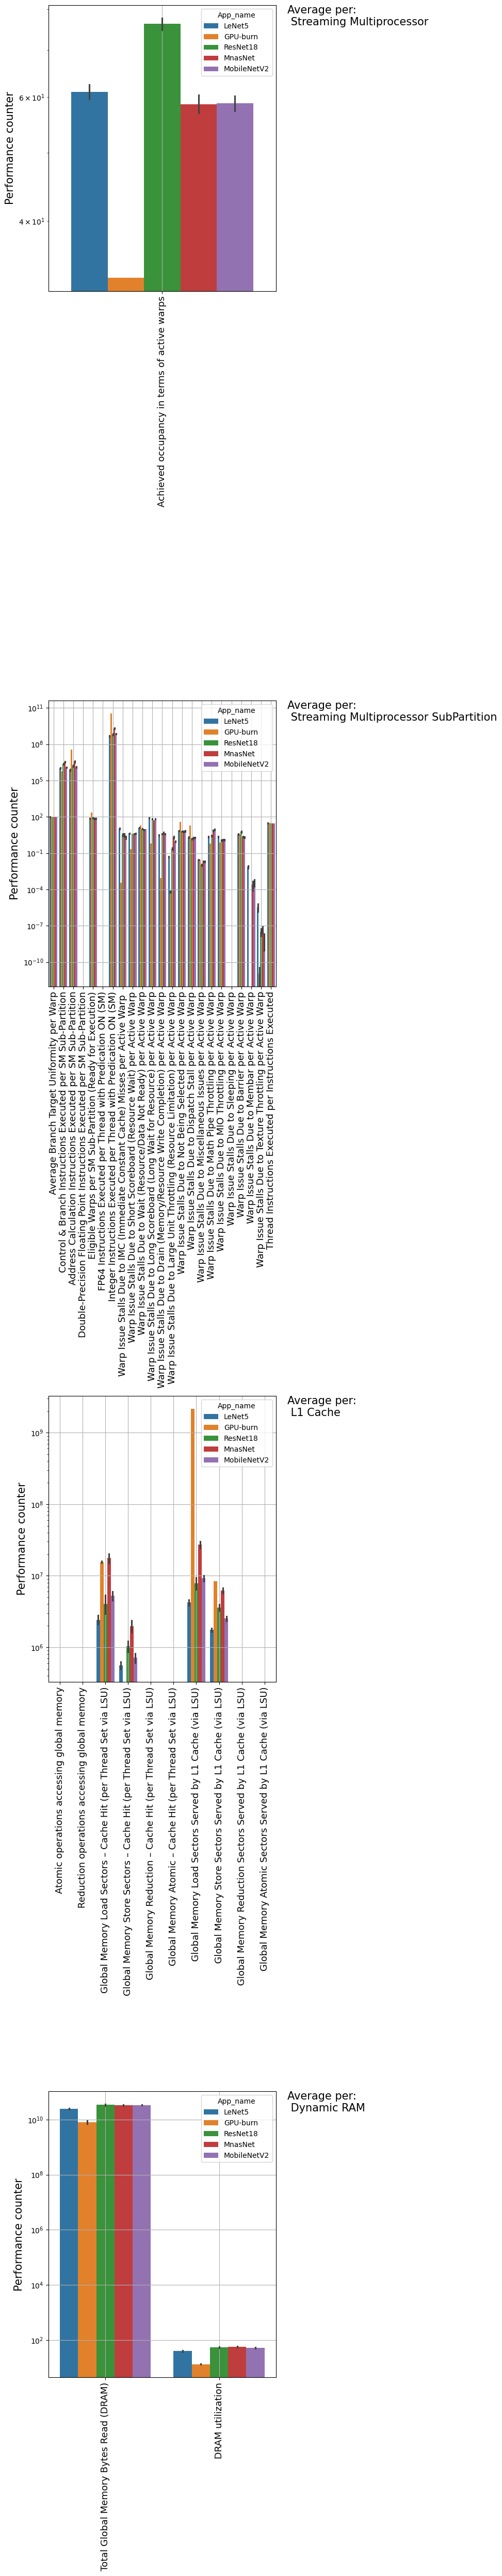

In [31]:
fig, ax = plt.subplots(4,1,figsize=(10,50))
for pivot_df_idx in range(len(list(dfs.values()))):
    HR_location = list(dfs.keys())[pivot_df_idx]
    # data_to_corr = dfs[HR_location].select_dtypes(include=['float64'])
    sns.barplot(data = dfs[HR_location], x='HR_metric_name', y='metric_value', hue='App_name', ax = ax[pivot_df_idx])
    # ax[pivot_df_idx].set_title(f"Grouped per: {HR_location}", fontsize=20, loc='right')
    ax[pivot_df_idx].text(1.05, 1.0, f'Average per: \n {HR_location}', transform=ax[pivot_df_idx].transAxes,
         ha='left', va='top', fontsize=15)
    ax[pivot_df_idx].grid()
    ax[pivot_df_idx].set_yscale('log')
    ax[pivot_df_idx].set_xlabel('Performance counter', fontsize=15)
    ax[pivot_df_idx].set_ylabel('Performance counter', fontsize=15)
    ax[pivot_df_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[pivot_df_idx].set_xticklabels([])
    ax[pivot_df_idx].set_xlabel('')
plt.tight_layout()

/tmp/ipykernel_57973/3905381030.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_57973/3905381030.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_57973/3905381030.py:13: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[metric_idx].set_yscale('log')
/tmp/ipykernel_57973/3905381030.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_57973/3905381030.py:13: UserWarning: Data has no positive values, and therefore cannot be lo

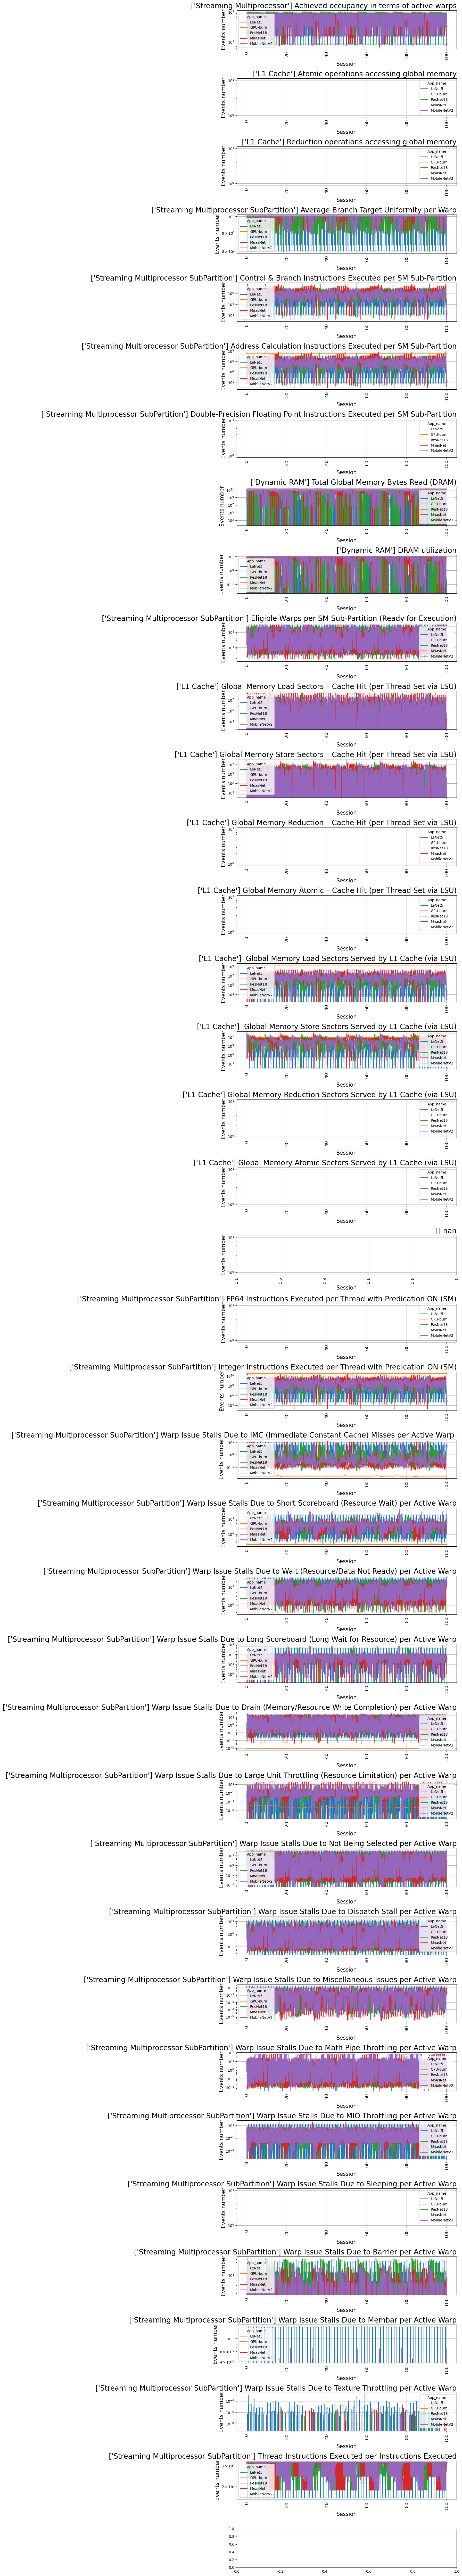

In [36]:
fig, ax = plt.subplots(38,1,figsize=(10,100))

for metric_idx in range(len(data_sheet_1['HR_metric_name'].unique())):
    metric_name = data_sheet_1['HR_metric_name'].unique()[metric_idx]
    data = data_sheet_1[data_sheet_1['HR_metric_name'] == metric_name]
    HR_location=data['HR_location'].unique()
    sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
    sns.scatterplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], alpha=0.15, legend=False)
    ax[metric_idx].set_title(f"{HR_location} {metric_name}", fontsize=20, loc='right')
    # ax[metric_idx].text(1.05, 1.0, f'Grouped per: \n {HR_location}', transform=ax[metric_idx].transAxes,
    #      ha='left', va='top', fontsize=15)
    ax[metric_idx].grid()
    ax[metric_idx].set_yscale('log')
    ax[metric_idx].set_xlabel('Session', fontsize=15)
    ax[metric_idx].set_ylabel('Events number', fontsize=15)
    ax[metric_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[df_idx].set_xticklabels([])
plt.tight_layout()

In [ ]:
for df in pivot

## Aggregated metrics

### Final remarks

### Future works
1. Use the correlation ID to correlate instructions with SASS code 
2. Explore the possibility to use sass_source_map or sass_metrics
3. 

### Metrics description
- SM Active cycles: Per ogni SM (in media) how many times there is at least an active warp?
- SM Active warps: Per ogni SM (in media) how many warps are active?